In [1]:
import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

class ArtLoader:
    """Load in art from artists as an array, batched and ready for tf"""
    
    def __init__(self, data_path):
        """set the path to the data directory"""
        # remove slash if it exists, accounted for in code below
        if data_path[-1] == '/':
            data_path = data_path[:-1]
        self.data_path = data_path

    def get_ponds(self, artist_name):
        """read in images from the prompt 
        'A beautiful painting of a waterlily pond, {artist}, Trending on artstation'
        for a particluar artist"""
        all_img_paths = os.listdir(f'{self.data_path}/{artist_name}')
        pond_img_list = [img_to_array(load_img(f'{self.data_path}/{artist_name}/{img_path}')) 
                         for img_path in all_img_paths  
                         if img_path[-5] in ['1', '2', '3']]
        return np.array(pond_img_list)
    
    def get_buildings(self, artist_name):
        """read in images from the prompt 
        'A beautiful painting of a building in a serene landscape, {artist}, Trending on artstation'
        for a particluar artist"""
        all_img_paths = os.listdir(f'{self.data_path}/{artist_name}')
        pond_img_list = [img_to_array(load_img(f'{self.data_path}/{artist_name}/{img_path}')) 
                         for img_path in all_img_paths  
                         if img_path[-5] in ['4', '5', '6']]
        return np.array(pond_img_list)

#def get_buildings(artist_path):

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50


topless_resnet = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='max' #avg, max
)

model = Sequential([
    Resizing(224, 224),
    topless_resnet
])

2022-04-29 22:07:33.485948: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
art_loader = ArtLoader(data_path = '../raw_data/batch 1')

In [40]:
data_path = '../raw_data/batch 1'
exclude = ['non-visual artist single images','styles single images', '.DS_Store']

all_artists = [artist for artist in os.listdir(data_path) if artist not in exclude]
len(all_artists)

143

In [46]:
#'Robert_Hubert'
from tqdm import tqdm

artist_features_list = []
ponds_list = []
artist_list = []

for artist in tqdm(all_artists[:]):
    
    artist_ponds = art_loader.get_ponds(artist)

    artist_features = model(artist_ponds).numpy()#.mean(axis = 0)

    for features, pond in zip(artist_features, artist_ponds):
        artist_features_list.append(features)
        ponds_list.append(pond)
        artist_list.append(artist)

100%|█████████████████████████████████████████| 143/143 [03:14<00:00,  1.36s/it]


In [81]:
# import tensorflow_transform as tft
# import tensorflow as tf
# results = tft.pca(test_features, 2, tf.float32)

In [73]:
from sklearn.decomposition import PCA
num_pcs = 5
pca = PCA(num_pcs)
pcs = pca.fit_transform(np.array(artist_features_list))

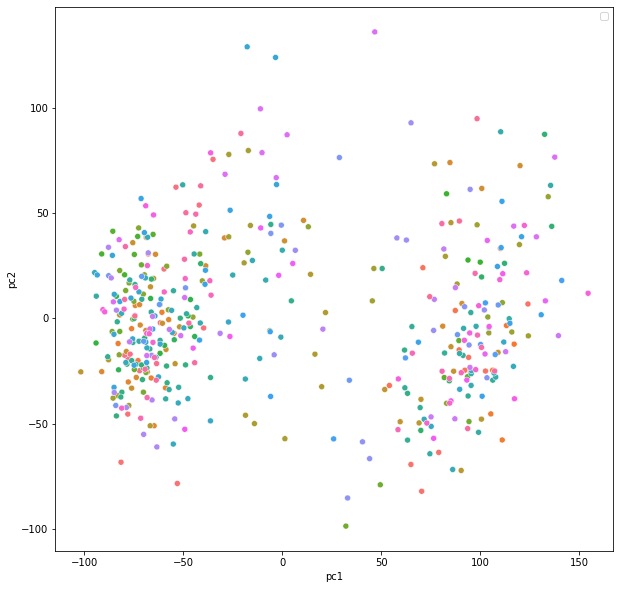

In [74]:
import seaborn as sns
import pandas as pd

pcs_dict = {f'pc{i+1}': pcs[:, i] for i in range(num_pcs)}
pcs_dict['artist'] = artist_list

pcs_df = pd.DataFrame(pcs_dict)

fig , ax = plt.subplots(figsize = (10, 10))
sns.scatterplot(data = pcs_df, x = 'pc1', y = 'pc2', hue = 'artist', ax = ax)
plt.legend('')

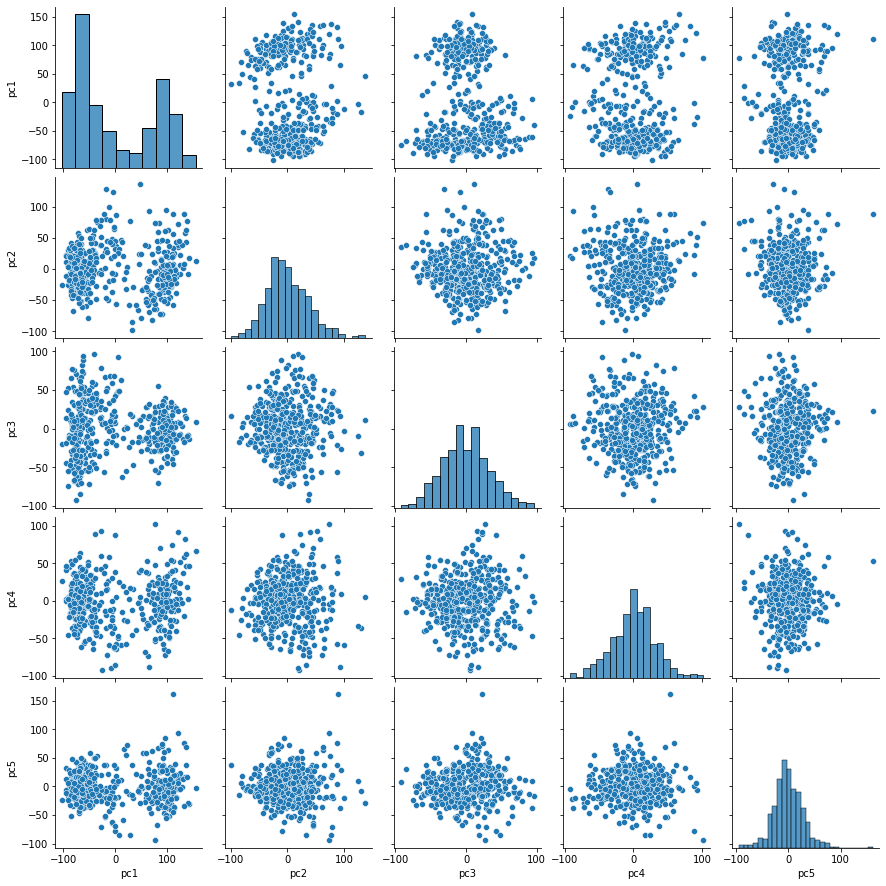

In [54]:
#sns.pairplot(data = pcs_df)

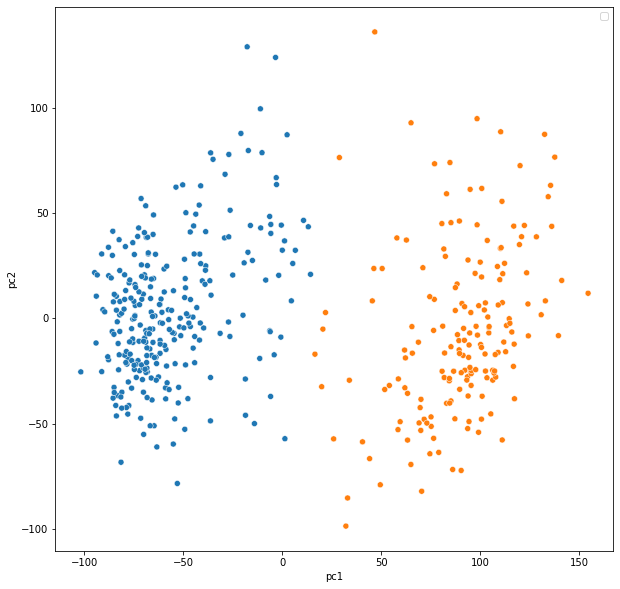

In [75]:
from sklearn.cluster import KMeans
k_cluster = KMeans(2)
k_cluster.fit(pcs)
pcs_df['k_labels'] = k_cluster.labels_

fig , ax = plt.subplots(figsize = (10, 10))
sns.scatterplot(data = pcs_df, x = 'pc1', y = 'pc2', hue = 'k_labels', ax = ax)
plt.legend('')

In [78]:
artist_df = pcs_df.groupby(['k_labels','artist']).mean().reset_index()
artist_df

,k_labels,artist,pc1,pc2,pc3,pc4,pc5
0,0,Aivazovsky_Ivan,-73.626747,-34.263943,5.328580,28.176371,-9.329827
1,0,Al_Halyan_Moosa,-75.241150,37.231419,-22.521965,-19.010551,6.922923
2,0,Andrews_Esao,-41.317112,25.807781,30.223703,46.879345,11.527853
3,0,Baizley_John,-90.210838,3.664974,-64.920616,1.654248,-8.692369
4,0,Bak_Karol,-10.238263,-18.853443,33.500000,63.975418,-57.677319
...,...,...,...,...,...,...,...
147,1,Walotsky_Ron,118.322189,14.846227,12.240239,40.277767,15.066799
148,1,Warhol_Andy,93.691109,-18.182274,-31.603811,-18.649281,23.823488
149,1,Yerka_Jacek,82.471588,29.487061,54.640621,21.070303,4.520178
150,1,Yuumei,99.643234,-28.590269,-0.843414,-3.257999,-4.094630


In [82]:
ponds_list[:10]

[array([[[231., 240., 252.],
         [231., 240., 252.],
         [232., 241., 254.],
         ...,
         [246., 252., 255.],
         [246., 252., 255.],
         [247., 253., 255.]],
 
        [[231., 240., 253.],
         [232., 240., 253.],
         [232., 241., 254.],
         ...,
         [246., 252., 255.],
         [245., 252., 255.],
         [246., 252., 255.]],
 
        [[231., 240., 253.],
         [232., 240., 254.],
         [232., 240., 254.],
         ...,
         [246., 252., 255.],
         [245., 252., 255.],
         [246., 252., 255.]],
 
        ...,
 
        [[162., 156., 145.],
         [177., 172., 164.],
         [217., 214., 209.],
         ...,
         [181., 170., 151.],
         [181., 170., 153.],
         [180., 169., 153.]],
 
        [[173., 167., 157.],
         [185., 180., 172.],
         [216., 213., 208.],
         ...,
         [184., 173., 155.],
         [181., 170., 155.],
         [179., 168., 153.]],
 
        [[189., 183., 175.],
 

In [79]:
pcs_df

,pc1,pc2,pc3,pc4,pc5,artist,k_labels
0,-72.128372,-24.802006,27.642036,-10.565032,19.810883,Éluard_Nusch,0
1,-77.944206,-18.889315,4.353250,24.955240,-6.288047,Éluard_Nusch,0
2,-79.688530,-17.421240,-33.728832,-13.282234,24.689728,Éluard_Nusch,0
3,-34.988781,75.546387,32.377644,-10.968144,53.653950,Emshwiller_Ed,0
4,-41.992439,53.832657,29.147562,-28.501846,4.372385,Emshwiller_Ed,0
...,...,...,...,...,...,...,...
444,89.562668,46.260670,2.535376,-13.640551,27.187536,Banksy,1
445,74.578217,10.345329,-28.730560,-12.031952,27.068851,Banksy,1
446,-76.889801,-16.918571,-37.349289,54.153126,-6.092425,Wong_Liam,0
447,-63.537788,-21.406809,11.013426,19.962008,-5.225406,Wong_Liam,0


In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def show_xy_images(in_df, image_zoom=1):
    fig, ax1 = plt.subplots(1,1, figsize=(10, 10))
    artists = []
    for _, c_row in in_df.iterrows():
        c_img = Image.open(c_row['path']).resize((64, 64))
        img = OffsetImage(c_img, zoom=image_zoom)
        ab = AnnotationBbox(img, (c_row['x'], c_row['y']), xycoords='data', frameon=False)
        artists.append(ax1.add_artist(ab))
    ax1.update_datalim(in_df[['x', 'y']])
    ax1.autoscale()
    ax1.axis('off')
show_xy_images(artist_df)

/var/folders/_n/rrz6mzy13l71h2mg878ykrv80000gn/T/ipykernel_38781/3539781581.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.imshow(np.array(ponds_list)[0].astype(int))


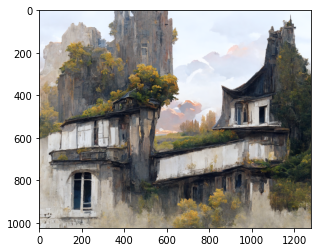

In [33]:
import matplotlib.pyplot as plt
plt.imshow(np.array(ponds_list)[0].astype(int))

In [16]:
# resize
# get features

In [ ]:
# just add pil images to a list, have a later funtion to convert them all to an array

In [ ]:
# prompts
artist = ""
pond = f'A beautiful painting of a waterlily pond, {artist}, Trending on artstation'
building = f'A beautiful painting of a building in a serene landscape, {artist}, Trending on artstation'

In [89]:
# idea for showing the images
# https://www.kaggle.com/code/kmader/hurricane-damage-overview